## Imports

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, minmax_scale, scale
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


import utils
import FD_ASE as myFDASE


## Functions

In [4]:
def cal_Importance(X_train, y_train, featureNames, save_dir, split_num):
    print('Start calculate the importance of the features...')

    nTrees = [50000]
    criterions = ['entropy']

    for nTree in nTrees: 
        for i in range(len(criterions)):
            print('Building the forest with %d trees...' % nTree)
            forest = RandomForestClassifier(n_estimators=nTree, criterion=criterions[i], verbose=0, n_jobs=4)
            print('Fitting the training data...')
            forest.fit(X_train, y_train)
            importances = forest.feature_importances_
            indices = np.argsort(importances)[::-1]
            featureNames_sorted = []
            featureNames_sorted = [featureNames[ind] for ind in indices]
            print('\n-----------------------\n' + 'Feature Importances:\n')
            local_prefix = (('nTree_%d_' + criterions[i]) % nTree)
            with open(os.path.join(save_dir, 'split_'+str(split_num)+'_'+local_prefix + '_FeatureImportance.log'), 'w') as log:
                for f in range(len(featureNames)): #print feature importances in descending order 
                    print("%2d) %-*s %f" % (f + 1, 30, featureNames_sorted[f], importances[indices[f]]))
                    log.write("%s\t%f\n" % (featureNames_sorted[f], importances[indices[f]]))
            print('\n\n' + 'Done ! \n\n')


def readResults(filepath):
    with open(filepath) as file:
        sorted_features = []
        importance_values = []
        for line in file.readlines():
            curLine = line.strip().split('\t')
            sorted_features.append(curLine[0])
            importance_values.append(float(curLine[1]))
        return sorted_features, importance_values


def disp_Importane(log_dir, num_attributes):
    file_list = os.listdir(log_dir)
    log_list = []
    for f in file_list:
        if f.split('.')[-1] == 'log':
            log_list.append(os.path.join(log_dir, f))
    num_logs = len(log_list)
    print('found {} log files'.format(num_logs))

    plt.figure(num=1, figsize=(30, 10))
    bar_width = 0.7
    opacity = 0.8
    x_pos = list(range(num_attributes))
    plt_cols = num_logs//2

    for i in range(num_logs):
        log_file = log_list[i]
        features, importance = readResults(log_file)
        ax = plt.subplot(2, plt_cols, i+1)
        ax.set_title(os.path.basename(log_file).split('.log')[0])
        plt.sca(ax)
        ax.yaxis.grid(linestyle=':', alpha=0.3)
        ax.bar(x_pos, importance, width=bar_width, color='b', align='center', alpha=opacity)
        plt.xticks(x_pos, features, rotation=45)
        # plt.legend(loc='upper right')
    
    plt.savefig(os.path.join(log_dir, 'Feature_Importances.png'))


def pca_of_reduced_features(X_train, save_dir, split_num):

    scal = StandardScaler()
    pca = PCA(n_components=np.shape(X_train)[1])

    pipe_scal_pca = Pipeline([('prepro', scal), ('pca', pca)])
    pipes = [pipe_scal_pca]

    for pipe in pipes:
        pipe.fit(X_train)
        varRatio = pipe.named_steps['pca'].explained_variance_ratio_
        with open(os.path.join(save_dir, 'split_'+str(split_num)+'_pca_var.log'), 'w') as log:
            log.write(str(pipe.named_steps['prepro']))
            log.write('\n-----------------------\n')
            for i in range(len(varRatio)):
                log.write(str(i+1) + '\t' + str(varRatio[i]) + '\n')
            log.write('\n-----------------------\n\n\n\n')


def save_np_to_txt(data, save_path):
    row, col = np.shape(data)
    print('data shape : ({}, {})'.format(row, col))
    with open(save_path, 'w') as fp:
        for i in range(row):
            for j in range(col):
                fp.write(str(data[i, j]) + ' ')
            fp.write('\n')

def load_npy_data(npy_dir, split_num, delete_attris_list=None):
    split_npy_dir = os.path.join(npy_dir, 'split_'+str(split_num))
    trainX = np.load(os.path.join(split_npy_dir, 'train_data.npy'))
    validationX = np.load(os.path.join(split_npy_dir, 'validation_data.npy'))
    testX = np.load(os.path.join(split_npy_dir, 'test_data.npy'))
    train_sourcename = np.load(os.path.join(split_npy_dir, 'train_sourcename.npy'))
    validation_sourcename = np.load(os.path.join(split_npy_dir, 'validation_sourcename.npy'))
    test_sourcename = np.load(os.path.join(split_npy_dir, 'test_sourcename.npy'))
    trainY = np.load(os.path.join(split_npy_dir, 'train_labels.npy'))
    validationY = np.load(os.path.join(split_npy_dir, 'validation_labels.npy'))
    testY = np.load(os.path.join(split_npy_dir, 'test_labels.npy'))
    predict_data = np.load(os.path.join(npy_dir, 'predict_data.npy'))
    predict_sourcename = np.load(os.path.join(npy_dir, 'predict_sourcename.npy'))
    header_name = np.load(os.path.join(npy_dir, 'header_name.npy'))

    if isinstance(delete_attris_list, list):
        header_name_list = list(header_name)
        delete_attris_index = []
        for da in delete_attris_list:
            indx = header_name_list.index(da)
            delete_attris_index.append(indx)
        trainX = np.delete(trainX, delete_attris_index, axis=-1)
        validationX = np.delete(validationX, delete_attris_index, axis=-1)
        testX = np.delete(testX, delete_attris_index, axis=-1)
        predict_data = np.delete(predict_data, delete_attris_index, axis=-1)

    return trainX, validationX, testX, \
           trainY, validationY, testY, \
           train_sourcename, validation_sourcename, test_sourcename, \
           predict_data, predict_sourcename, header_name





### Parameters

In [5]:
split_repeat = 10
featureNames = ['Pivot_Energy','Flux1000','PL_Index','Variability_Index','Frac_Variability','Flux_Band1','Flux_Band2','Flux_Band3','Flux_Band4','Flux_Band5','Flux_Band6','Flux_Band7','Flux_Band8']
check_info = [ # [data_npy_dir, mission_str]
    [r'datasets/NPY_DATA_A', 'Mission_A'],
    [r'datasets/NPY_DATA_B', 'Mission_B'],
]

## Feature Importance

Start calculate the importance of the features...
Building the forest with 5 trees...
Fitting the training data...

-----------------------
Feature Importances:

 1) Frac_Variability               0.313360
 2) PL_Index                       0.238590
 3) Variability_Index              0.219218
 4) Pivot_Energy                   0.198573
 5) Flux_Band1                     0.015896
 6) Flux_Band2                     0.008728
 7) Flux1000                       0.003405
 8) Flux_Band3                     0.002229
 9) Flux_Band8                     0.000000
10) Flux_Band7                     0.000000
11) Flux_Band6                     0.000000
12) Flux_Band5                     0.000000
13) Flux_Band4                     0.000000


Done ! 


Start calculate the importance of the features...
Building the forest with 5 trees...
Fitting the training data...

-----------------------
Feature Importances:

 1) PL_Index                       0.251002
 2) Frac_Variability               0.219252
 3) 

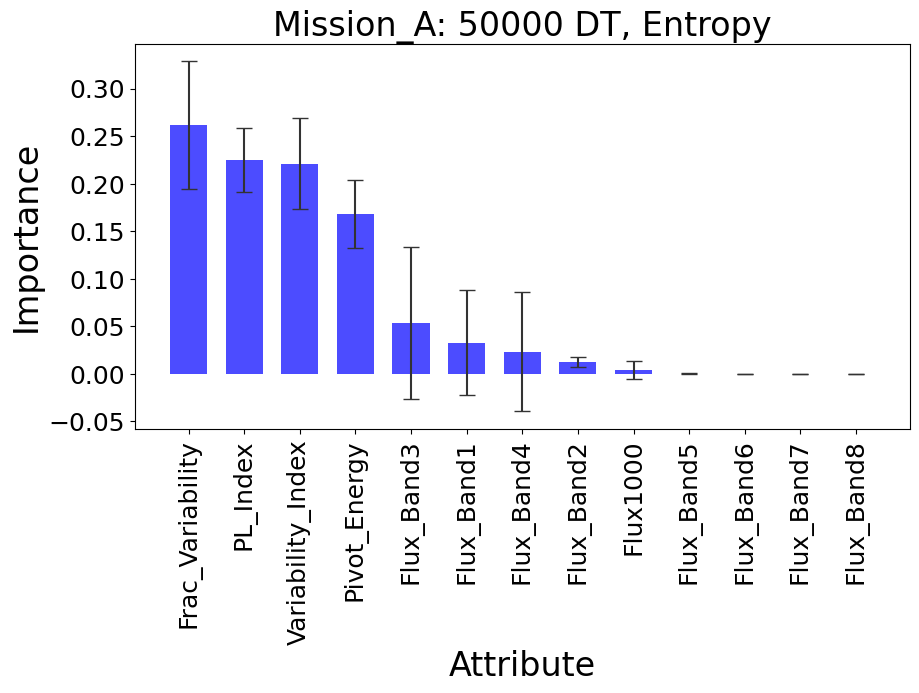

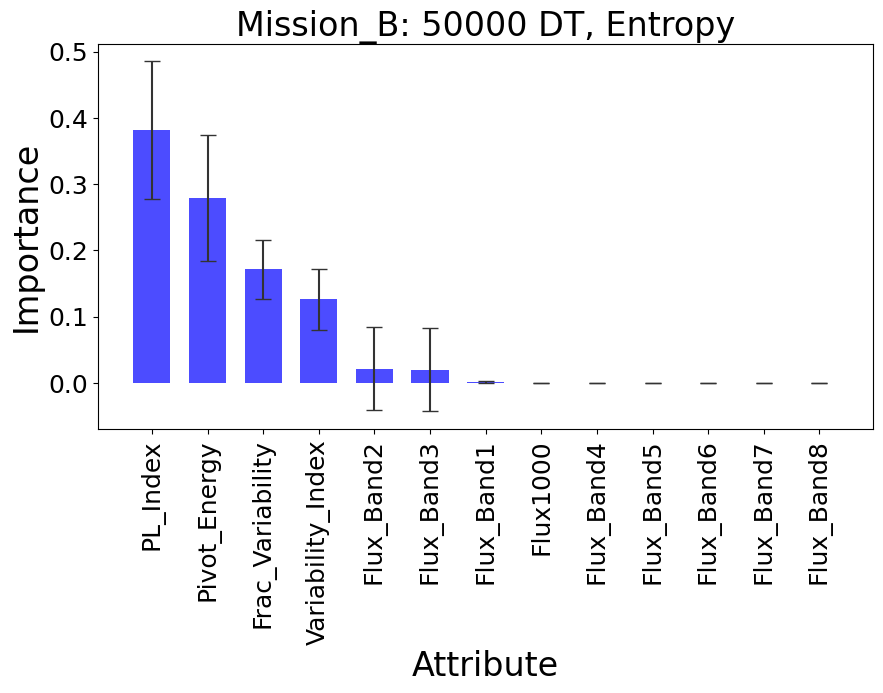

In [6]:

for data_npy_dir, mission_str in check_info:
    result_dir = os.path.join('RESULTS', mission_str, 'Feature_Importance_RF')
    os.makedirs(result_dir, exist_ok=True)


    # calculate the feature importance
    for split_num in range(1, split_repeat+1):
        trainX, validationX, testX, \
        trainY, validationY, testY, \
        train_sourcename, validation_sourcename, test_sourcename, \
        predict_data, predict_sourcename, header_name = utils.load_npy_data(data_npy_dir, split_num, delete_attris_list=['Unc_Flux1000', 'Unc_PL_Index', 'Unc_Frac_Variability'])
        cal_Importance(trainX, trainY, featureNames, result_dir, split_num)
    

    # load the results
    file_list = os.listdir(result_dir)
    log_list = []
    for f in file_list:
        if f.split('.')[-1] == 'log':
            log_list.append(os.path.join(result_dir, f))
    num_logs = len(log_list)
    print('found {} log files'.format(num_logs))

    fi_dict = {}
    for feat_name in featureNames:
        if feat_name not in fi_dict:
            fi_dict[feat_name] = []
    for log_file in log_list:
        features, importance = readResults(log_file)
        for i in range(len(features)):
            fi_dict[features[i]].append(importance[i])

    mean_std_fi_dict = {}
    for k, v in fi_dict.items():
        mean_std_fi_dict[k] = [np.mean(v), np.std(v, ddof=1)]
    new_sys = sorted(mean_std_fi_dict.items(),  key=lambda d: d[1][0], reverse=True)

    feat_list, mean_list, std_list = [], [], []
    for d in new_sys:
        feat_list.append(d[0])
        mean_list.append(d[1][0])
        std_list.append(d[1][1])
    

    # plot the results
    fig = plt.figure(figsize=(10,5))
    index = np.arange(len(feat_list))*1.5

    plt.bar(index, mean_list, width=1, yerr=std_list, error_kw = {'ecolor':'0.2', 'capsize':6}, alpha=0.7, color='b')
    plt.yticks(fontsize=18)
    plt.xticks(index, feat_list, fontsize=18, rotation=90)
    plt.xlabel("Attribute", fontsize=24)
    plt.ylabel("Importance", fontsize=24)
    plt.title(mission_str+': 50000 DT, Entropy', fontsize=24)

### PCA

found 10 log files
found 10 log files


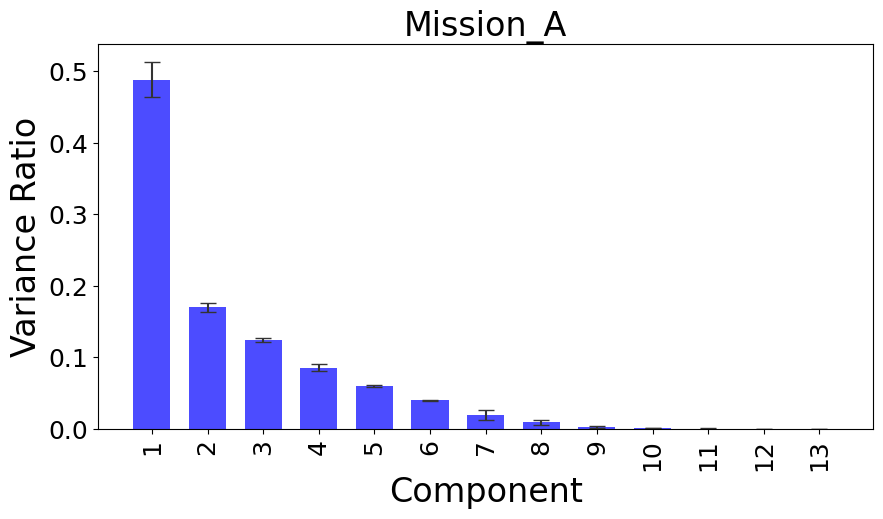

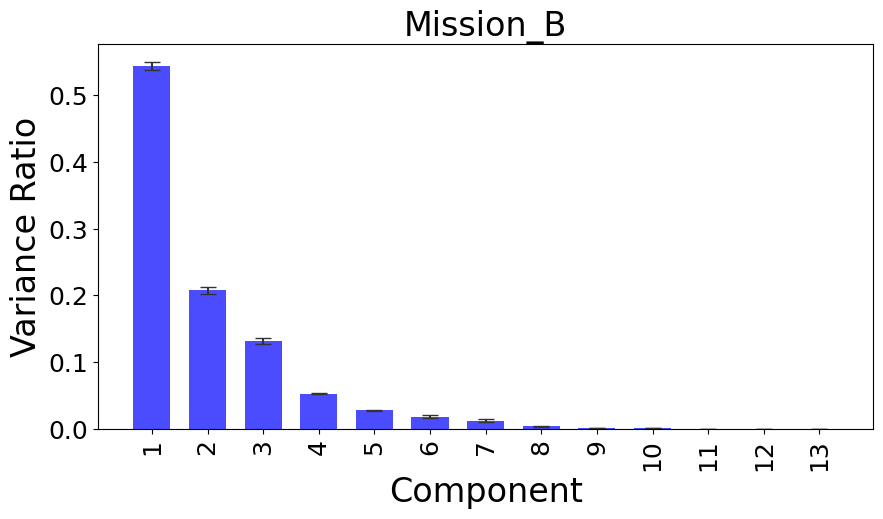

In [8]:
for data_npy_dir, mission_str in check_info:
    result_dir = os.path.join('RESULTS', mission_str, 'PCA')
    os.makedirs(result_dir, exist_ok=True)

    # calculate PCA
    for split_num in range(1, split_repeat+1):
        trainX, validationX, testX, \
        trainY, validationY, testY, \
        train_sourcename, validation_sourcename, test_sourcename, \
        predict_data, predict_sourcename, header_name = utils.load_npy_data(data_npy_dir, split_num, delete_attris_list=['Unc_Flux1000', 'Unc_PL_Index', 'Unc_Frac_Variability'])
        pca_of_reduced_features(trainX, result_dir, split_num)
    

    # load the results
    file_list = os.listdir(result_dir)
    log_list = []
    for f in file_list:
        if f.split('.')[-1] == 'log':
            log_list.append(os.path.join(result_dir, f))
    num_logs = len(log_list)
    print('found {} log files'.format(num_logs))

    comp_dict = {}
    for c in range(1, np.shape(trainX)[1]+1):
        if c not in comp_dict:
            comp_dict[c] = []
    for log_file in log_list:
        with open(log_file, 'r') as fp:
            for line in fp.readlines():
                if '\t' in line:
                    words = line.strip().split('\t')
                    comp_name = int(words[0])
                    comp_var = float(words[1])
                    comp_dict[comp_name].append(comp_var)

    mean_std_comp_dict = {}
    for k, v in comp_dict.items():
        mean_std_comp_dict[k] = [np.mean(v), np.std(v, ddof=1)]
    new_sys = sorted(mean_std_comp_dict.items(),  key=lambda d: d[1][0], reverse=True)

    comp_list, mean_list, std_list = [], [], []
    for d in new_sys:
        comp_list.append(d[0])
        mean_list.append(d[1][0])
        std_list.append(d[1][1])


    # plot the results
    fig = plt.figure(figsize=(10,5))
    index = np.arange(len(comp_list))*1.5

    plt.bar(index, mean_list, width=1, yerr=std_list, error_kw = {'ecolor':'0.2', 'capsize':6}, alpha=0.7, color='b')
    plt.yticks(fontsize=18)
    plt.xticks(index, comp_list, fontsize=18, rotation=90)
    plt.xlabel("Component", fontsize=24)
    plt.ylabel("Variance Ratio", fontsize=24)
    plt.title(mission_str, fontsize=24)


### FDASE

calculating individual contribution ...
iC 0 / 12: 0.98147
iC 1 / 12: 0.97281
iC 2 / 12: 0.98659
iC 3 / 12: 0.97968
iC 4 / 12: 0.53289
iC 5 / 12: 0.69956
iC 6 / 12: 0.72930
iC 7 / 12: 0.97081
iC 8 / 12: 0.97726
iC 9 / 12: 0.97584
iC 10 / 12: 0.85836
iC 11 / 12: 0.65017
iC 12 / 12: 0.66702

sorted iC A':
attribute 2: 0.98659
attribute 0: 0.98147
attribute 3: 0.97968
attribute 8: 0.97726
attribute 9: 0.97584
attribute 1: 0.97281
attribute 7: 0.97081
attribute 10: 0.85836
attribute 6: 0.72930
attribute 5: 0.69956
attribute 12: 0.66702
attribute 11: 0.65017
attribute 4: 0.53289
partial intrinsic dimension D = 1.55695

calculating individual contribution ...
iC 0 / 12: 0.98085
iC 1 / 12: 0.97368
iC 2 / 12: 0.98484
iC 3 / 12: 0.97865
iC 4 / 12: 0.53531
iC 5 / 12: 0.71129
iC 6 / 12: 0.72567
iC 7 / 12: 0.96857
iC 8 / 12: 0.98068
iC 9 / 12: 0.97529
iC 10 / 12: 0.87557
iC 11 / 12: 0.67284
iC 12 / 12: 0.67318

sorted iC A':
attribute 2: 0.98484
attribute 0: 0.98085
attribute 8: 0.98068
attribute 

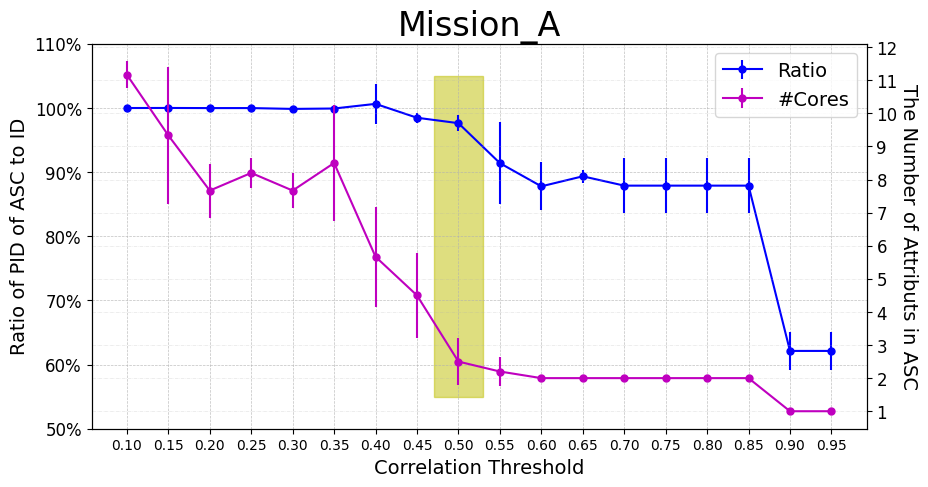

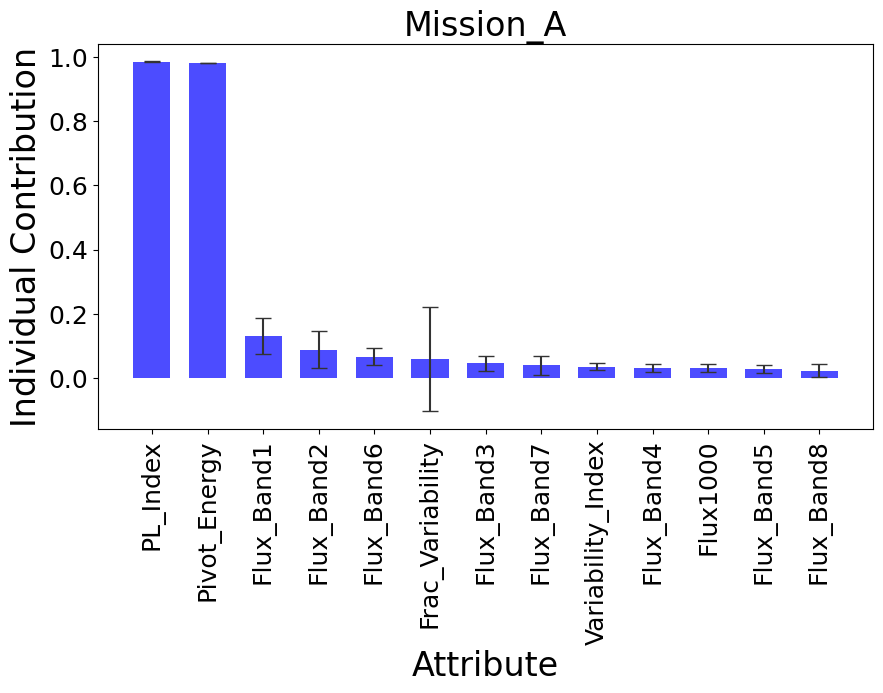

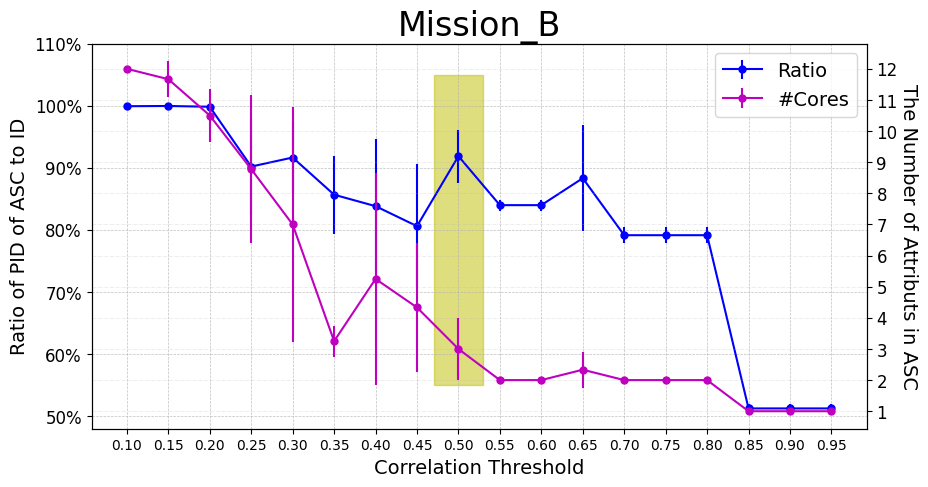

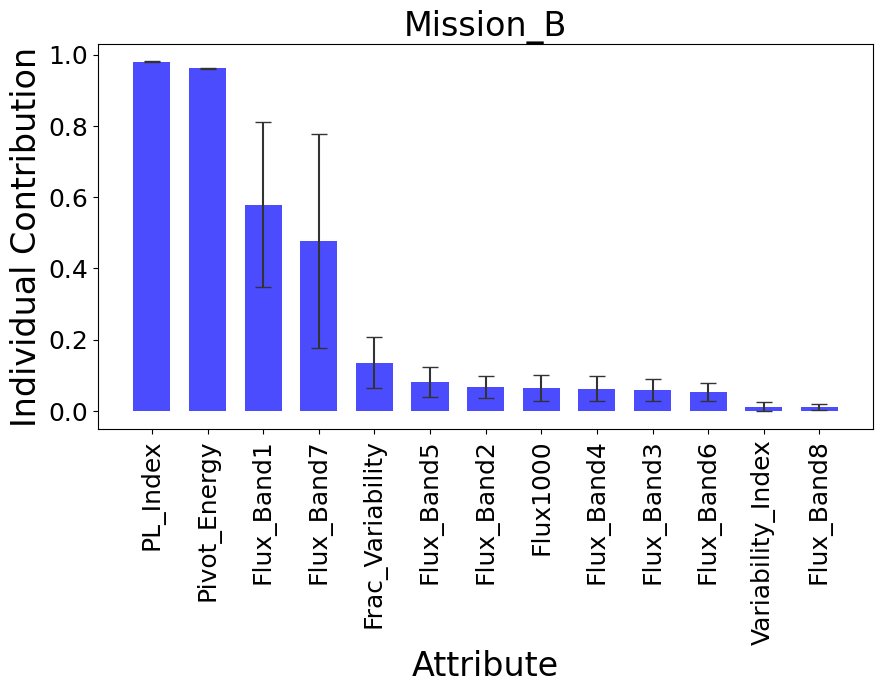

In [9]:
R = 50
checked_eps = 0.5


for data_npy_dir, mission_str in check_info:
    result_dir = os.path.join('RESULTS', mission_str, 'FDASE')
    os.makedirs(result_dir, exist_ok=True)


    # calculate the FDASE results with scanning correlation threshold
    for split_num in range(1, split_repeat+1):
        trainX, _, _, \
        trainY, _, _, \
        train_sourcename, _, _, \
        _, _, header_name = utils.load_npy_data(data_npy_dir, split_num, delete_attris_list=['Unc_Flux1000', 'Unc_PL_Index', 'Unc_Frac_Variability'])

        all_importance_dict = {}
        all_importance_dict['core'] = []
        all_importance_dict['numer of core'] = []
        all_importance_dict['importance of core'] = []
        all_importance_dict['ratio with iD'] = []
        all_importance_dict['Eposilon'] = []

        attribute_data = minmax_scale(trainX, axis=0)
        A_, iCs, iD = myFDASE.cal_iC(attribute_data, R, small_ic=0.1, show_fit=False)
        all_importance_dict['iD'] = iD

        ase_result_log = os.path.join(result_dir, 'split_'+str(split_num)+'_'+'ASE_result.log')
        result_excel = os.path.join(result_dir, 'split_'+str(split_num)+'_'+'FDASE_result.xlsx')

        with open(ase_result_log, 'a') as fp:
            for epsilon in range(5, 100, 5):
                epsilon = epsilon/100

                print('epsilon: {}'.format(round(epsilon, 3)))
                print('##################################################################################')
                fp.write('epsilon: {}\n'.format(round(epsilon, 3)))
                fp.write('##################################################################################\n')

                Gs, Bs, C = myFDASE.FD_ASE(attribute_data, R, epsilon, A_)

                if Gs is not None:
                    ll = len(Gs)
                    if ll != 0:
                        print('\n\n\n----------------------------------')
                        fp.write('\n\n\n----------------------------------\n')

                        print('partial intrinsic dimension D = %.5f\n' % (iD))
                        fp.write('partial intrinsic dimension D = {:.5f}\n\n'.format(iD))
                        print('----------------------------------')
                        fp.write('----------------------------------\n')
                        print('R = %d, epsilon = %.5f' % (R, epsilon))
                        fp.write('R = %d, epsilon = %.5f\n' % (R, epsilon))
                        print('G\t\tB')
                        fp.write('G\t\tB\n')
                        for l in range(ll):
                            print(Gs[l], '\t', Bs[l])
                            fp.write('{}\t{}\n'.format(Gs[l], Bs[l]))
                        print('Core:', C)
                        fp.write('Core: {}\n'.format(C))
                        pd_asc = myFDASE.computepD(attribute_data[:, C], R)
                        print('info ratio: pd_asc {}/ iD {} = {}%'.format(round(pd_asc, 5), round(iD, 5), round(pd_asc/iD*100, 3)))
                        print('----------------------')
                        fp.write('info ratio: pd_asc {}/ iD {} = {}%\n'.format(round(pd_asc, 5), round(iD, 5), round(pd_asc/iD*100, 3)))
                        fp.write('----------------------\n')


                        importance_dict_sorted = myFDASE.cal_importance(attribute_data, R, A_, C)
                        for indx in range(len(header_name)):
                            atrr_name = header_name[indx] + '\n' + str(indx)
                            if indx in importance_dict_sorted.keys():
                                if atrr_name not in all_importance_dict.keys():
                                    all_importance_dict[atrr_name] = [importance_dict_sorted[indx]]
                                else:
                                    all_importance_dict[atrr_name].append(importance_dict_sorted[indx])
                            else:
                                all_importance_dict[atrr_name] = ''
                        
                        all_importance_dict['core'].append(C)
                        all_importance_dict['numer of core'].append(len(C))
                        all_importance_dict['importance of core'].append(pd_asc)
                        all_importance_dict['ratio with iD'].append(pd_asc/iD)
                        all_importance_dict['Eposilon'].append(round(epsilon, 3))

                    else:
                        print('find nothing')
                        fp.write('find nothing\n')
                else:
                    print('Algorithm/Parameters Error !!!')
                    fp.write('Algorithm/Parameters Error !!!\n')
                print('##################################################################################\n\n\n\n\n')
                fp.write('##################################################################################\n\n\n\n\n')

        all_importance_dict = pd.DataFrame(all_importance_dict)
        all_importance_dict.to_excel(result_excel, sheet_name='importance',
                                    float_format='%.5f')
        


    # plot the results and deside the correlation threshold
    all_excel_files = utils.return_all_files(result_dir, 'xlsx')
    print('total {} excel files'.format(len(all_excel_files)))
    ase_result_dict = {}

    # for excel_path in [all_excel_files[0]]:
    for excel_path in all_excel_files:
        df = pd.read_excel(excel_path)
        header_name_list = list(df.head())
        all_data = np.array(df)

        index_core_list = header_name_list.index('core')
        index_num_core = header_name_list.index('numer of core')
        index_ratio = header_name_list.index('ratio with iD')
        index_eps = header_name_list.index('Eposilon')

        for i in range(len(all_data)):
            core_list_str = all_data[i][index_core_list]
            num_core = int(all_data[i][index_num_core])
            ratio = float(all_data[i][index_ratio])
            eps = float(all_data[i][index_eps])
            k = str(eps) + '_' + core_list_str
            if k not in ase_result_dict.keys():
                ase_result_dict[k] = [{'num_core':num_core, 'ratio':ratio}]
            else:
                ase_result_dict[k].append({'num_core':num_core, 'ratio':ratio})

    plot_dict = {}
    klist = list(ase_result_dict.keys())
    for epsilon in range(5, 100, 5):
        epsilon = epsilon/100
        eps_list, num_core_list, ratio_list = [], [], []
        plot_dict[epsilon] = {'num_core_list':[], 'ratio_list':[]}

        for k in klist:
            if str(epsilon) == k.split('_')[0]:
                eps_list.append(epsilon)
                num_core_list.append(ase_result_dict[k][0]['num_core'])
                plot_dict[epsilon]['num_core_list'].append(ase_result_dict[k][0]['num_core'])
                ratio_list_1 = []
                for d in ase_result_dict[k]:
                    ratio_list_1.append(d['ratio'])
                    plot_dict[epsilon]['ratio_list'].append(d['ratio'])
                ratio_list.append(ratio_list_1)

    plot_eps_list, plot_num_core_mean_list, plot_num_core_std_list, plot_ratio_mean_list, plot_ratio_std_list = [], [], [], [], []
    for k, v in plot_dict.items():
        if len(v['num_core_list']) > 0:
            plot_eps_list.append(k)
            if len(v['num_core_list']) == 1:
                plot_num_core_mean_list.append(v['num_core_list'][0])
                plot_num_core_std_list.append(0)
            else:
                plot_num_core_mean_list.append(np.mean(v['num_core_list']))
                plot_num_core_std_list.append(np.std(v['num_core_list'], ddof=1))

            if len(v['ratio_list']) == 1:
                plot_ratio_mean_list.append(v['ratio_list'][0])
                plot_ratio_std_list.append(0)
            else:
                plot_ratio_mean_list.append(np.mean(v['ratio_list']))
                plot_ratio_std_list.append(np.std(v['ratio_list'], ddof=1))
            # print(k, plot_num_core_mean_list[-1], plot_num_core_std_list[-1], plot_ratio_mean_list[-1], plot_ratio_std_list[-1])


    fig, ax1 = plt.subplots(figsize=(10,5))
    ax2 = ax1.twinx()
    sline = ax1.errorbar(plot_eps_list, plot_ratio_mean_list, plot_ratio_std_list, label='Ratio', capsize=0, fmt='o-', ms=5, c='b')
    kline = ax2.errorbar(plot_eps_list, plot_num_core_mean_list, plot_num_core_std_list, label='#Cores', capsize=0, fmt='o-', ms=5, c='m')
    ax1.set_xlabel('Correlation Threshold', fontsize=14)
    ax1.set_ylabel('Ratio of PID of ASC to ID', fontsize=14)
    ax1.set_yticks([i for i in np.arange(0.5,1.1,0.1)], [str(i)+'%' for i in range(50,111,5) if i%10 == 0], fontsize=12)
    ax2.set_ylabel('The Number of Attributs in ASC', fontsize=14, rotation=270, labelpad=15)
    ax2.set_yticks([i for i in range(1,13)], [str(i) for i in range(1,13)], fontsize=12)
    ax1.grid(linestyle='--', linewidth=0.5, alpha=0.8)
    ax2.grid(linestyle='-.', linewidth=0.4, alpha=0.4)
    rect = plt.Rectangle((0.47,0.55),0.06,0.5, alpha=0.5, color='y')
    ax1.add_patch(rect)
    plt.legend([sline, kline, ], ['Ratio', '#Cores'], loc=0, fontsize=14)
    plt.xticks(plot_eps_list, fontsize=12)
    plt.title(mission_str, fontsize=24)



    # plot the ic
    attri_col_list = [i for i in range(7,20)]
    all_attri_data = []
    for excel_path in all_excel_files:
        df = pd.read_excel(excel_path)
        header_name_list = list(df.head())
        all_data = np.array(df)
        index_eps = header_name_list.index('Eposilon')
        for row_indx in range(len(all_data)):
            eps = float(all_data[row_indx][index_eps])
            if eps == checked_eps:
                break
        attri_data = all_data[row_indx, attri_col_list]
        all_attri_data.append(attri_data)
    all_attri_data = np.array(all_attri_data, dtype=np.float64)
    mean_data = np.mean(all_attri_data, axis=0)
    std_data = np.std(all_attri_data, ddof=1, axis=0)
    indices = np.argsort(mean_data)[::-1]
    mean_data_sorted = []
    mean_data_sorted = [mean_data[ind] for ind in indices]
    std_data_sorted = []
    std_data_sorted = [std_data[ind] for ind in indices]
    attri_name_list_sorted = []
    attri_name_list_sorted = [featureNames[ind] for ind in indices]

    fig = plt.figure(figsize=(10,5))
    index = np.arange(len(mean_data))*1.5
    plt.bar(index, mean_data_sorted, width=1, yerr=std_data_sorted, error_kw = {'ecolor':'0.2', 'capsize':6}, alpha=0.7, color='b')
    plt.yticks(fontsize=18)
    plt.xticks(index, attri_name_list_sorted, fontsize=18, rotation=90)
    plt.xlabel("Attribute", fontsize=24)
    plt.ylabel("Individual Contribution", fontsize=24)
    plt.title(mission_str, fontsize=24)


### Normalize data for FDIDWT

In [10]:
for data_npy_dir, mission_str in check_info:
    result_dir = os.path.join('RESULTS', mission_str, 'FDIDWT')
    os.makedirs(result_dir, exist_ok=True)

    for split_num in range(1, split_repeat+1):
        trainX, validationX, testX, \
        _, _, _, \
        _, _, _, \
        predictX, _, _ = load_npy_data(data_npy_dir, split_num, delete_attris_list=['Unc_Flux1000', 'Unc_PL_Index', 'Unc_Frac_Variability'])

        trainX_processed = scale(trainX, axis=0)
        validationX_processed = scale(validationX, axis=0)
        testX_processed = scale(testX, axis=0)
        predictX_processed = scale(predictX, axis=0)

        save_np_to_txt(trainX_processed, os.path.join(result_dir, 'split_'+str(split_num)+'_trainX.txt'))
        save_np_to_txt(validationX_processed, os.path.join(result_dir, 'split_'+str(split_num)+'_validationX.txt'))
        save_np_to_txt(testX_processed, os.path.join(result_dir, 'split_'+str(split_num)+'_testX.txt'))
        save_np_to_txt(predictX_processed, os.path.join(result_dir, 'split_'+str(split_num)+'_predictX.txt'))


data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (3494, 13)
data shape : (435, 13)
data shape : (439, 13)
data shape : (2291, 13)
data shape : (1799, 13)
data shape : (224, 13)
data shape : 

### Change to MATLAB for IDWT

In [ ]:
### change to run step2_analysis_FDIDWT_iwt.m ### 
# exit()
### and go on ###